## 가격 범위에 따른 자산 가치 변화 시뮬레이션

----

#### 포지션 총 자산가치($V$) 

포지션의 총 자산가치는 아래와 같이 평가할 수 있습니다.

$$
V = X\cdot P_c + Y
$$

* $X$ : 포지션에 예치된 실제 X 토큰의 갯수
* $Y$ : 포지션에 예치된 실제 Y 토큰의 갯수
* $P_c$ : 현재 가격 ($P = \frac{Y}{X}$)
* $V$ : 포지션의 총 자산가치

#### 포지션에 예치되어 있는 토큰 갯수 계산

$$
X = (\frac{1}{\sqrt{P_c}} - \frac{1}{\sqrt{P_h}}) \cdot L \\
Y = (\sqrt{P_c} - \sqrt{P_l}) \cdot L \\
$$


* $P_c$ : 현재 두 토큰의 가격 ($P = \frac{Y}{X}$)
* $P_l$ : 포지션의 하방 가격선
* $P_h$ : 포지션의 상방 가격선
* $L$ : 포지션의 유동성 크기

### Helper Functions

In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

def calculate_amount(p_c, p_l, p_h, lq=100):
    """ 범위에 따른 자산 갯수
    @param p_c 현재 가격
    @param p_l 포지션의 하방 가격선
    @param p_h 포지션의 상방 가격선
    @param lq  유동성 크기
    """
    
    if (p_c < p_h):
        X = 1/math.sqrt(p_c) - 1/math.sqrt(p_h)
    else:
        # 현재 가격이 포지션 범위를 초과할 경우, X의 갯수는 0 
        X = 0        
        Y = math.sqrt(p_h) - math.sqrt(p_l)
        return X * lq, Y * lq

    if (p_c > p_l):
        Y = (math.sqrt(p_c) - math.sqrt(p_l))
    else:
        # 현재 가격이 포지션 범위 밑으로 내려갈 경우, Y의 갯수는 0
        X = 1/math.sqrt(p_l) - 1/math.sqrt(p_h)
        Y = 0        
    return X * lq, Y * lq

def calculate_valuation(p_c, p_l, p_h):
    """ 자산 가치 평가
    @param p_c 현재 가격
    @param p_l 포지션의 하방 가격선
    @param p_h 포지션의 상방 가격선
    """
    # 범위에 따른 자산 가치 = (x 갯수 * price + y 갯수)
    X, Y = calculate_amount(p_c, p_l, p_h)
    return p_c * X + Y

def calculate_EGL(k, lower=0.5, upper=2.0):
    """포지션의 가격 범위에 따라 자산가치 변동율 계산
    @params k 가격 변동 수준 계수, (1.1이면 10% 가격 상승, 0.9이면 10% 가격 하락)
    @params lower 포지션의 하방 가격선 (현재 가격을 1로 두었을 때, 상대 값)
    @params upper 포지션의 상방 가격선 (현재 가격을 1로 두었을 때, 상대 값)
    """    
    # 초기 가치
    init_value = calculate_valuation(1.0, lower, upper)
    
    # 현재 가치 (가격이 K 배 만큼 변화하였을 때)
    curr_value = calculate_valuation(k, lower, upper)
    
    return (curr_value) / init_value

def calculate_fee_multiplier(price, lower=0.5, upper=2.0):
    """ 포지션에 따른 범위에 따른 Fee Multiplier
    => 전체 범위로 넣었을 때의 유동성 대비 집중화된 유동성으로 넣었을 때의 자산 가치로 파악
    => 동일한 유동성을 공급할 경우, (전체 범위으로 공급했을때의 필요 자산가치) / (특정 가격범위만 넣었을 때의 필요 자산가치)
    """
    full_range = calculate_valuation(price, 0, np.infty)
    concentrated_range = calculate_valuation(price, lower, upper)
    return full_range / concentrated_range

## 단순 시뮬레이션 예시



![](https://imgur.com/ZAD7BZa.png)

위처럼 가상자산 시장에서의 토큰 가치는 실시간으로 변동합니다. 이렇게 변화하는 장 상황에서 가격 범위에 따라 어떻게 자산 가치가 변화하는지를 시뮬레이션해보겠습니다.

#### 시뮬레이션 상황

* Stable X volatile 페어에 예치
* current Price는 1:1

가격은 Volatile 토큰의 가격이라 가정하고, Volatile 토큰의 가격이 Stable Coin 대비 % 범위에 넣었는지를 두겠습니다.

#### 예시 1. 포지션을 (50% ~ 200%) 범위로 설정했을 때, 자산 가치 변화

In [50]:
# volatile의 자산가치가 2배가 되었을 때, LP 포지션의 가치는 1.20배
egl = calculate_EGL(2, 0.5, 2.0)

print(f"EGL : {egl:.3%}")

EGL : 120.711%


#### 예시 2. 포지션을 (0% ~ 200%) 범위로 설정했을 때, 자산 가치 변화

In [51]:
# volatile의 자산가치가 2배가 되었을 때, LP 포지션의 가치는 1.09배
egl = calculate_EGL(2, 0, 2.0)

print(f"EGL : {egl:.3%}")

EGL : 109.384%


#### 예시 3. 포지션을 (50% ~ infinity%) 범위로 설정했을 때, 자산 가치 변화

In [52]:
# volatile의 자산가치가 2배가 되었을 때 LP 포지션의 가치는 1.64배
egl = calculate_EGL(2, 0.5, np.inf)

print(f"EGL : {egl:.3%}")

EGL : 164.075%


#### 예시 4. 가격 범위에 따른 EGL 비교

<IPython.core.display.Javascript object>


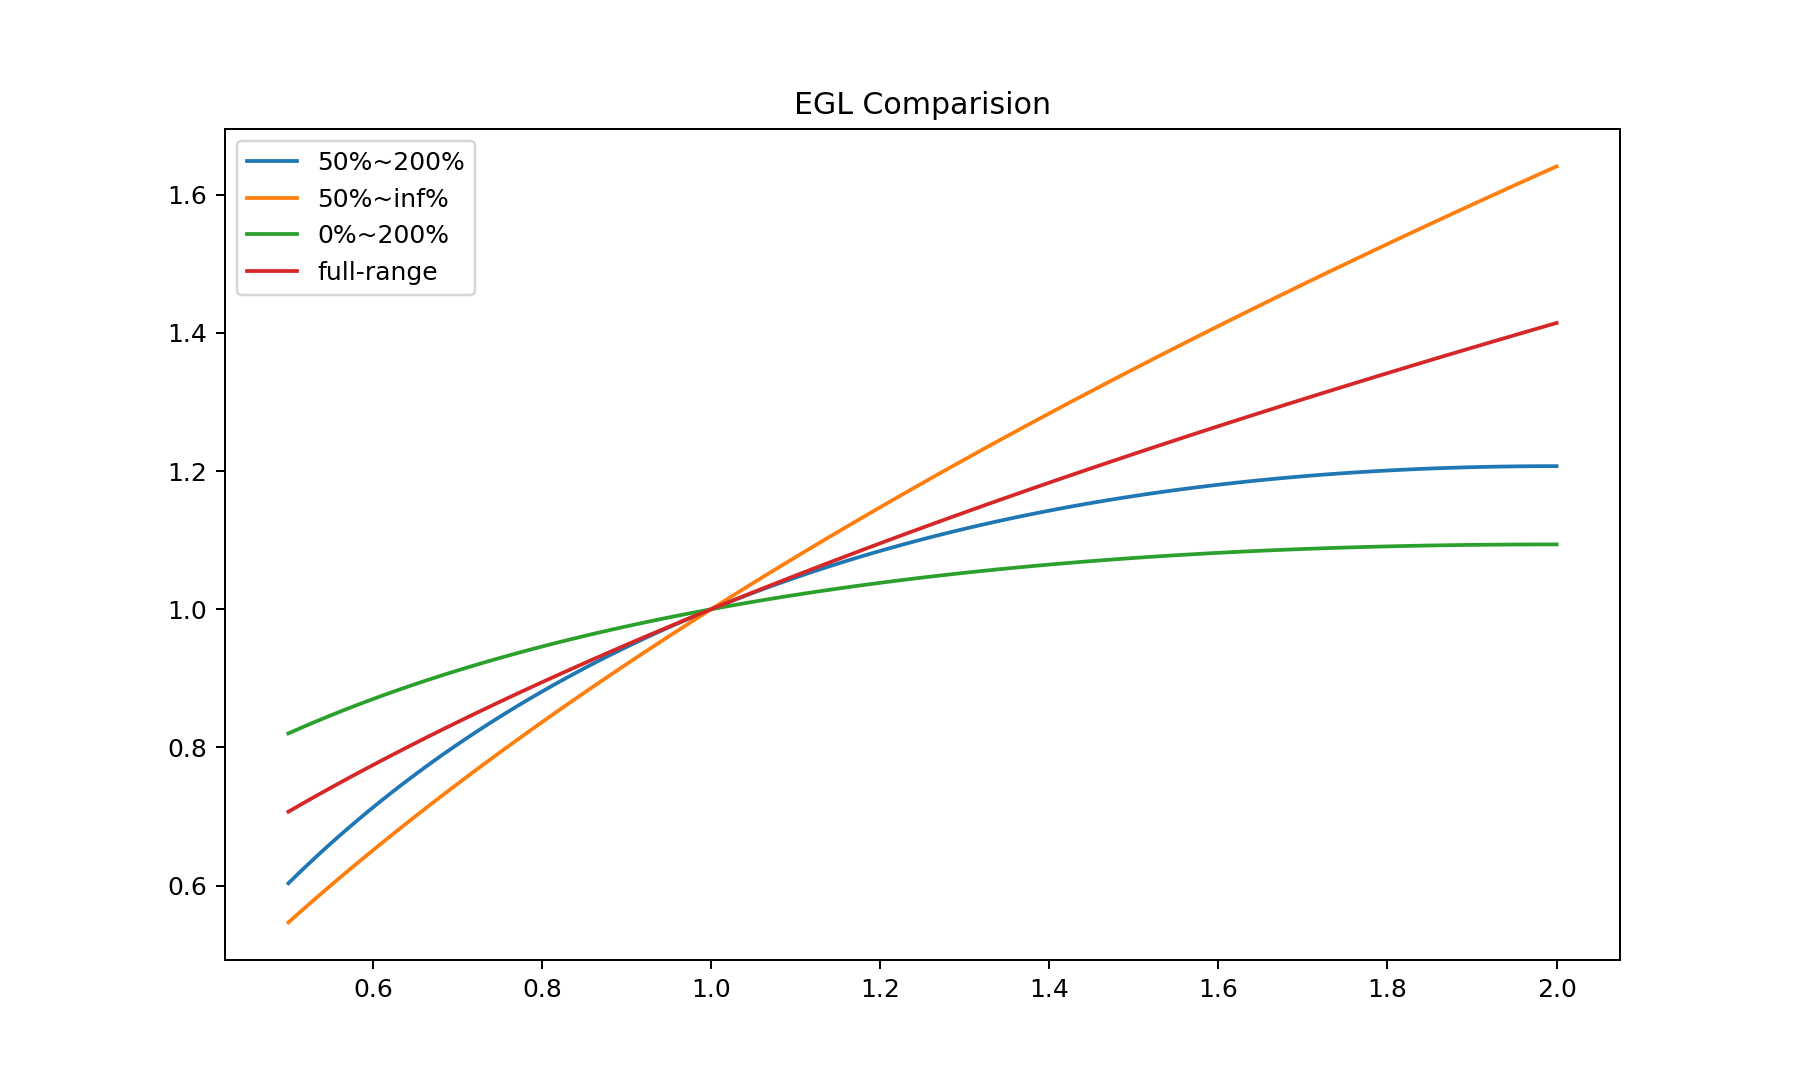

In [53]:
lower = 0.5
upper = 2.0
count = 100

xs = np.linspace(lower, upper, num=count)
concentrated_ys = [calculate_EGL(x, lower, upper) for x in xs]
upside_ys = [calculate_EGL(x, lower, np.inf) for x in xs]
downside_ys = [calculate_EGL(x, 0, upper) for x in xs]
full_ys = [calculate_EGL(x, 0, np.inf) for x in xs]

fig = plt.figure(figsize=(10, 6))
plt.title("EGL Comparision")

plt.plot(xs,concentrated_ys,label=f"{lower:.0%}~{upper:.0%}")
plt.plot(xs,upside_ys,label=f"{lower:.0%}~inf%")
plt.plot(xs,downside_ys,label=f"0%~{upper:.0%}")
plt.plot(xs,full_ys, label="full-range")

plt.legend()
plt.show()

#### 예시 5. 예치 전략에 따른 EGL 비교

* `USDC 100%` : 스테이블로 모든 자산을 가지고 있는 경우
* `ETH 100%` : 이더리움으로 모든 자산을 가지고 있는 경우
* `USDC-ETH Pair LP(0~infinity)` : 풀에 예치한 경우

<IPython.core.display.Javascript object>


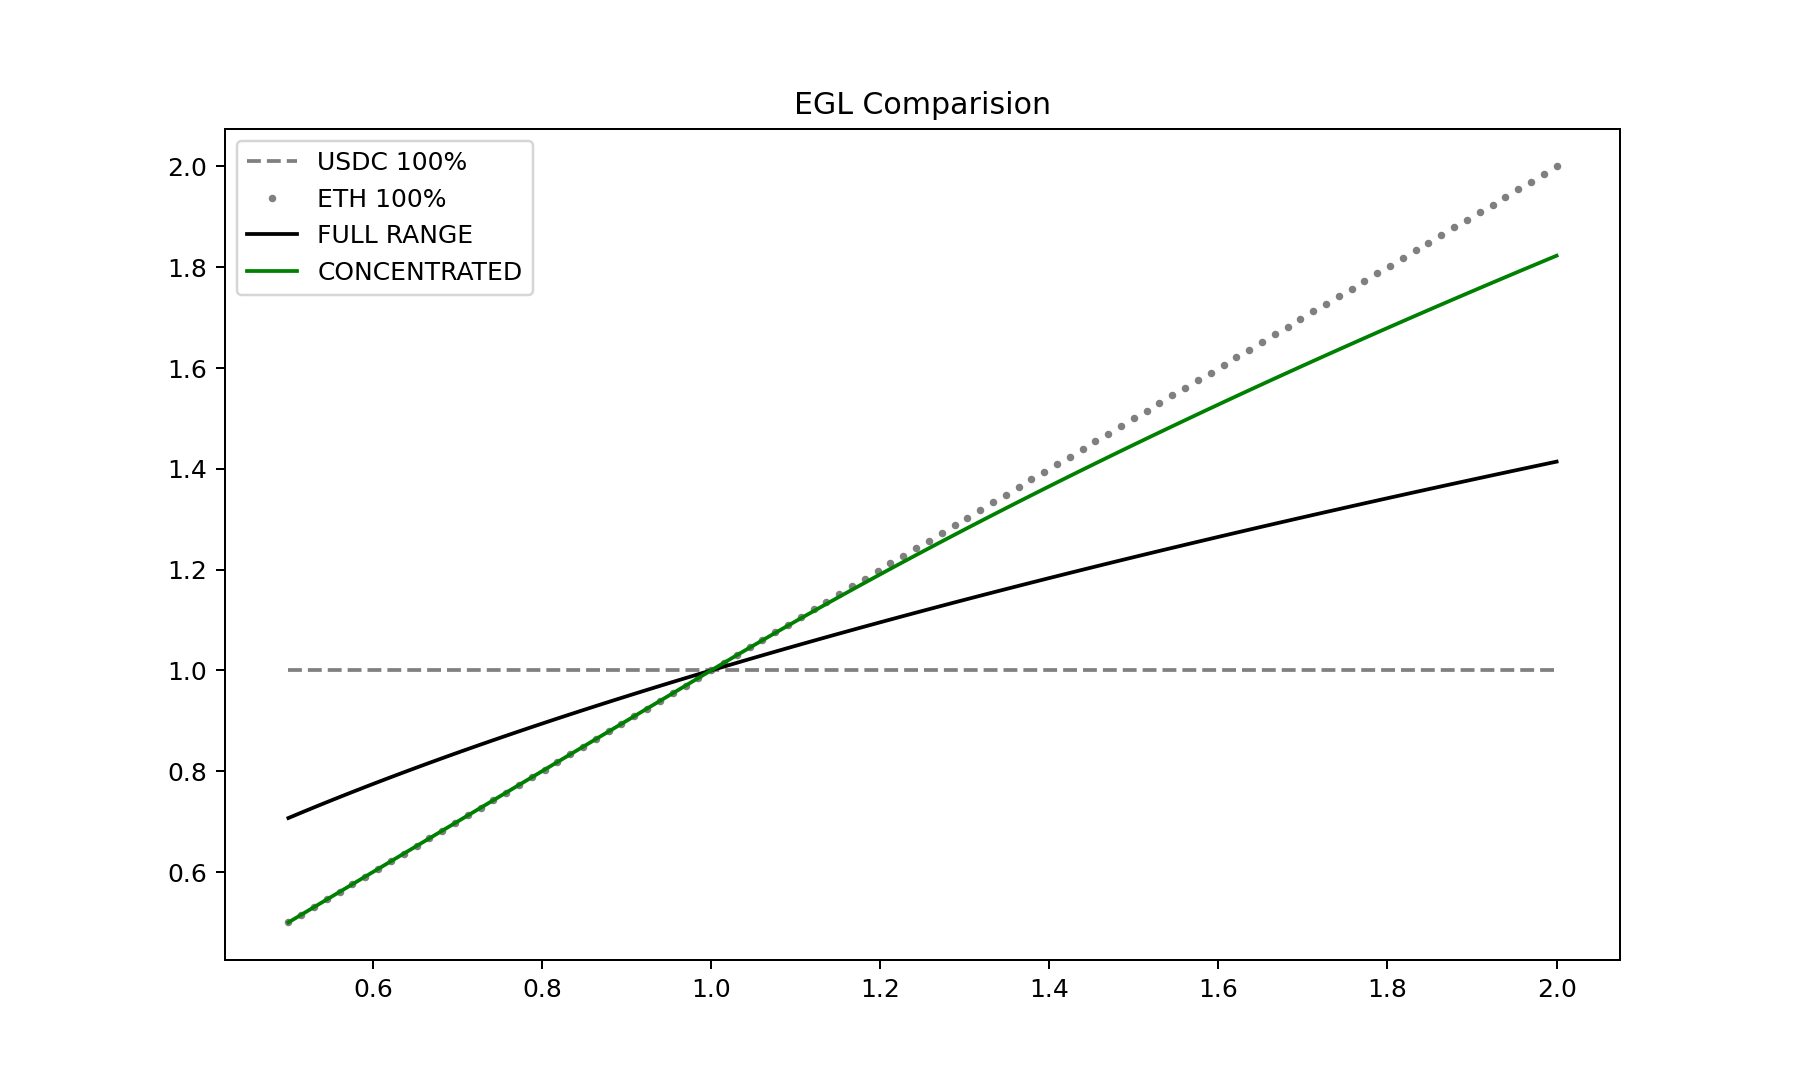

interactive(children=(FloatSlider(value=0.5, description='lower', max=1.0), FloatLogSlider(value=2.0, descript…

In [54]:
%matplotlib notebook

lower = 0.5
upper = 2.0
count = 100

xs = np.linspace(lower, upper, num=count)
all_usdc = [1.0] * count
all_usdt = xs
all_LP = [calculate_EGL(x, 0, np.inf) for x in xs]
all_concentrated_LP = [calculate_EGL(x, lower, upper) for x in xs]

fig = plt.figure(figsize=(10,6))
plt.title("EGL Comparision")
plt.plot()

plt.plot(xs,all_usdc,'--',label="USDC 100%", c='gray')
plt.plot(xs,all_usdt,'o', markersize=2, label="ETH 100%",c='gray')
plt.plot(xs,all_LP,'-' ,label="FULL RANGE", c='black')

lp_plot = plt.plot(xs,all_concentrated_LP,'-' ,label="CONCENTRATED", c='green')[0]

plt.legend(loc='upper left')

def update(
    lower=widgets.FloatSlider(min=0, max=1, value=0.5),
    upper=widgets.FloatLogSlider(min=0, max=3,steps=1000,value=2),
):
    lp_plot.set_ydata([calculate_EGL(x, lower, upper) for x in xs])

    fig.canvas.draw_idle()
    
widgets.interact(update)
plt.show()

### 요약

![](https://imgur.com/zlqlw3M.png)